***Andrew Plum***<br/>
***CS 474***<br/>
***11/18/2024***

## HW 5: Build a many-to-one RNN for sentiment analysis

In this homework, you will build a many-to-one RNN for sentiment analysis, i.e., classify reviews into two categories: positive (1) and negative(0).

**Dataset**: 

    -IMDb Movie Reviews for binary sentiment classification
    -A set of 50,000 reviews with labels. All reviews have been cleaned.

In [1]:
#Feel free to import other necassary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import time

from tqdm import tqdm # you may need to install this package
tqdm.pandas()
from collections import Counter


**For Keras Implementation**

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam as Adam_tf
from tensorflow.keras.layers import Dense, LSTM


In [9]:
"""
# For py3.11
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras.models import Sequential
from keras.layers import LSTM, Dense
"""

"\n# For py3.11\nimport os\nos.environ['KERAS_BACKEND'] = 'tensorflow'\n\nfrom keras.models import Sequential\nfrom keras.layers import LSTM, Dense\n"

**For PyTorch Implementation**

In [3]:
import torch
from torch import nn
from torch.optim import Adam as Adam_torch
from torch.utils.data import TensorDataset, DataLoader


#### 1. Load the dataset
In the my_imdb.csv file, the 'review' column has preprocessed texts of user reviews, and the 'label' has binary catogories. 1 indicates positive comments, and 0 means negative comments.

In [5]:
# read processed data
df = pd.read_csv('my_imdb.csv')
print(df.shape)
df.head()

(50000, 2)


,review,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


#### 2. Text vectorization
Text vectorization converts texts into sequences of numeric values

- The **vocabulary** is a set that contains all unique words in the dataset.
- The **vectorizer** is dictionary that contains every word in the vocabulary set and its index
- The **padding** creates vectors with fixex length, e.g., 256
- Feel free to change the following code to use other text vectorization approaches, e.g., TF-IDF or BoW.

2.1 Create the vocabulary and the vectorizer

In [7]:
# get all words
text = df.review.values
words = ' '.join(text)
words = words.split() 

# build vocabulary
vocab = sorted(Counter(words), key=Counter(words).get, reverse=True)
ID2W = dict(enumerate(vocab, 1))
ID2W[0] = '<PAD>' # special word for paddding purpose, and the index is 0
vectorizer = {word: ID for ID, word in ID2W.items()}
vectorizer

{'.': 1,
 ',': 2,
 'I': 3,
 '-': 4,
 'movie': 5,
 'film': 6,
 'The': 7,
 'one': 8,
 '!': 9,
 'like': 10,
 'It': 11,
 '?': 12,
 'time': 13,
 'This': 14,
 'good': 15,
 'character': 16,
 'story': 17,
 'would': 18,
 'get': 19,
 'make': 20,
 'see': 21,
 'really': 22,
 'even': 23,
 'scene': 24,
 'much': 25,
 'well': 26,
 'people': 27,
 'bad': 28,
 'great': 29,
 'way': 30,
 'show': 31,
 'made': 32,
 'thing': 33,
 'first': 34,
 'also': 35,
 'could': 36,
 'think': 37,
 'life': 38,
 'But': 39,
 'know': 40,
 'go': 41,
 'And': 42,
 'plot': 43,
 'seen': 44,
 'actor': 45,
 'watch': 46,
 'A': 47,
 'say': 48,
 'year': 49,
 'love': 50,
 'many': 51,
 'end': 52,
 'two': 53,
 'acting': 54,
 'look': 55,
 'never': 56,
 'There': 57,
 'In': 58,
 'little': 59,
 'best': 60,
 'ever': 61,
 'better': 62,
 'work': 63,
 'If': 64,
 'take': 65,
 'come': 66,
 'He': 67,
 'find': 68,
 'man': 69,
 'part': 70,
 'still': 71,
 'something': 72,
 'want': 73,
 'give': 74,
 'back': 75,
 'lot': 76,
 'real': 77,
 'performance': 78

2.2 Sample results of vectorization

In [9]:
print('Text sample:', text[0])
num_vec = [vectorizer[w] for w in text[0].split()]
print('Coverted vector:',  len(num_vec), num_vec,)

Text sample: One reviewer mentioned watching Oz episode hooked . They right , exactly happened . The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word . It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many . . Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish . . . . scuffle , death stare , dodgy dealing shady agreement never far away . I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance . . . OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard

2.3 Apply vectorization to the whole dataset
- Apply padding to create sequences with fixed length
- The final dataset with with numeric features is (X, Y)

In [13]:
# text vectorization and padding
vecs = [[vectorizer[w] for w in r.split()] for r in tqdm(text)] # vecs contains the vectorized reviews of varying length
seq_length = 256
    
X = np.full((len(vecs), seq_length), 0, dtype=int) # create matrix whose shape is (50000, 256) initialized with 0
for i, vec in enumerate(vecs): 
    X[i, :len(vec)] = np.array(vec)[:seq_length] # of each vectorized review, grab only up to the first 256 values and store in the row of X

print('Text vectors:', X.shape)
Y = df.label.to_numpy()
print('Labels:', Y.shape)

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:03<00:00, 15629.53it/s]


Text vectors: (50000, 256)
Labels: (50000,)


In [14]:
print('Original vector:\n', vec[0])
print('Results with padding:\n', X[0])

Original vector:
 291
Results with padding:
 [  191  1083   930    81  3724   186  3030     1   118   114     2   527
   500     1     7    34    33  3086  3724  5192 15234    24   490     2
   126   114   259  7473     1  5550     2    31  6620  2169 11285     1
    14    31   923  2106  2177   591     2   289   490     1   677  3805
     2   242   262   259     1    11   342  9227 10121   279 14927 22637
 12715  4100 55917     1    11   758  1332 29362  1094     2  4665  1963
  1105  2317  2079   822   243 55918     2 16586   237  4338     1 18349
  1094   261    51     1     1 25451     2  8327     2 12516     2 15235
     2  5060     2  7897     2  2344     1     1     1     1 22638     2
   251  4076     2  7347  1674  8574  9867    56   144   160     1     3
    18    48   193  1066    31   587    96    41    31  2759     1  4156
   106   281  4057  2373   166     2   798  1179     2   798   740     1
     1     1  9227   793   100     1     7    34   186     3    61   130
  3086

## Keras Implementation - Professor said we could implement using keras

#### 3. Prepare the training, validation and test sets. 15 points
- Use 50% data for training, 20% for validation, and 30% for testing
- Set the batch size to 128

In [19]:
# Split the data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, random_state = 0)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_test, Y_test, test_size = 0.6, random_state = 0)

print("Training set:")
print(X_train.shape)
print(Y_train.shape)
print()
print("Validation set:")
print(X_validation.shape)
print(Y_validation.shape)
print()
print("Test set:")
print(X_test.shape)
print(Y_test.shape)
print()

# batch size set in next cell with other hyperparameters


Training set:
(25000, 256)
(25000,)

Validation set:
(10000, 256)
(10000,)

Test set:
(15000, 256)
(15000,)



#### 4. Build a many-to-one RNN. 40 points
- GRU or LSTM is preferred

In [45]:
input_size = 256
hidden_size = 512
output_size = 1
batch_size = 128
time_step = 1
lr = 0.001

# reshape data to include time_step

X_train_reshaped = X_train.reshape(X_train.shape[0], time_step, input_size)
X_validation_reshaped = X_validation.reshape(X_validation.shape[0], time_step, input_size)
X_test_reshaped = X_test.reshape(X_test.shape[0], time_step, input_size)

# build keras LSTM RNN

TF_LSTM_RNN = Sequential()

TF_LSTM_RNN.add(LSTM(hidden_size, return_sequences = True, input_shape = (time_step, input_size)))
TF_LSTM_RNN.add(LSTM(hidden_size))

TF_LSTM_RNN.add(Dense(output_size, activation = "sigmoid")) 

TF_LSTM_RNN.compile(optimizer = Adam_tf(learning_rate = lr), loss = "binary_crossentropy", metrics = ["accuracy"])
TF_LSTM_RNN.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1, 512)            1574912   
                                                                 
 lstm_10 (LSTM)              (None, 512)               2099200   
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 3,674,625
Trainable params: 3,674,625
Non-trainable params: 0
_________________________________________________________________


#### 5. Train the above model. 30 points

Epoch 1/20
196/196 [==============================] - 17s 45ms/step - loss: 0.6975 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.5167
Epoch 2/20
196/196 [==============================] - 10s 51ms/step - loss: 0.6909 - accuracy: 0.5262 - val_loss: 0.6935 - val_accuracy: 0.5134
Epoch 3/20
196/196 [==============================] - 10s 49ms/step - loss: 0.6895 - accuracy: 0.5329 - val_loss: 0.6931 - val_accuracy: 0.5177
Epoch 4/20
196/196 [==============================] - 10s 50ms/step - loss: 0.6883 - accuracy: 0.5375 - val_loss: 0.6938 - val_accuracy: 0.5165
Epoch 5/20
196/196 [==============================] - 9s 47ms/step - loss: 0.6879 - accuracy: 0.5382 - val_loss: 0.6930 - val_accuracy: 0.5225
Epoch 6/20
196/196 [==============================] - 10s 50ms/step - loss: 0.6868 - accuracy: 0.5423 - val_loss: 0.6935 - val_accuracy: 0.5186
Epoch 7/20
196/196 [==============================] - 11s 55ms/step - loss: 0.6859 - accuracy: 0.5458 - val_loss: 0.6925 - val_accuracy: 

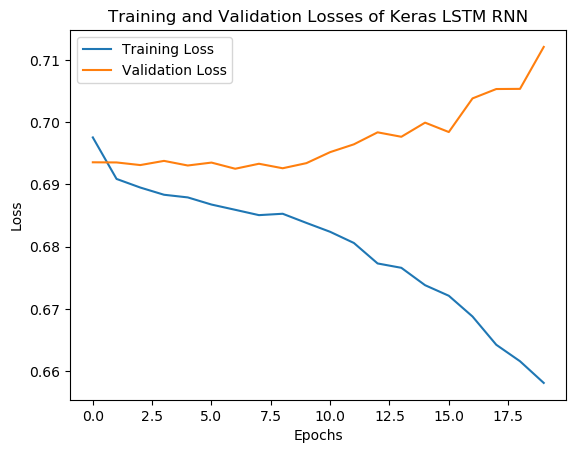

In [47]:
num_epochs = 20

start_time = time.time()

TF_LSTM_RNN_training_history = TF_LSTM_RNN.fit(X_train_reshaped, Y_train, validation_data = (X_validation_reshaped, Y_validation), epochs = num_epochs, batch_size = batch_size)

# print train time
elapsed_time = ((time.time() - start_time) / 60)
print()
print("Elapsed model training time:\n{:.2f} minutes".format(elapsed_time))


plt.figure()
plt.plot(TF_LSTM_RNN_training_history.history["loss"], label = "Training Loss")
plt.plot(TF_LSTM_RNN_training_history.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Losses of Keras LSTM RNN")
plt.legend()
plt.show()


#### 6. Calculate and report the performance of your model on the training and test set. 15 points
- Calculate the accuracies on the training and test sets
- Print out the confusion matrix of model results on the test set: https://scikit-learn.org/dev/modules/generated/sklearn.metrics.confusion_matrix.html

In [49]:
# evaluate model

Y_train_hat = TF_LSTM_RNN.predict(X_train_reshaped)
Y_test_hat = TF_LSTM_RNN.predict(X_test_reshaped)
Y_train_hat = (Y_train_hat > 0.5).astype(int)
Y_test_hat = (Y_test_hat > 0.5).astype(int)

train_accuracy = accuracy_score(Y_train, Y_train_hat)
test_accuracy = accuracy_score(Y_test, Y_test_hat)

print()

# print accuracies using accuracy score

print("Using accuracy score:")
print()
print("Training accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)
print()

# print accuracies using evaluate

train_loss, train_accuracy = TF_LSTM_RNN.evaluate(X_train_reshaped, Y_train)
test_loss, test_accuracy = TF_LSTM_RNN.evaluate(X_test_reshaped, Y_test)

print()
print("Using evaluate:")
print()
print("Training accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)
print("Training loss", train_loss)
print("Test loss", test_loss)
print()

# confusion matrices

print("Confusion matrix for train set:\n", confusion_matrix(Y_train, Y_train_hat))
print()
print("Confusion matrix for test set:\n", confusion_matrix(Y_test, Y_test_hat))
print()


469/469 [==============================] - 3s 6ms/step

Using accuracy score:

Training accuracy: 0.63016
Test accuracy: 0.5258

469/469 [==============================] - 4s 8ms/step - loss: 0.7094 - accuracy: 0.5258

Using evaluate:

Training accuracy: 0.6301599740982056
Test accuracy: 0.5257999897003174
Training loss 0.6406683325767517
Test loss 0.7093936800956726

Confusion matrix for train set:
 [[8275 4164]
 [5082 7479]]

Confusion matrix for test set:
 [[4209 3314]
 [3799 3678]]



## PyTorch Implementation - Don't grade this attempt, did it to learn something new and would love any feedback you may have

#### 3. Prepare the training, validation and test sets. 15 points
- Use 50% data for training, 20% for validation, and 30% for testing
- Set the batch size to 128

In [7]:
# Split the data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, random_state = 0)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_test, Y_test, test_size = 0.6, random_state = 0)

print("Training set:")
print(X_train.shape)
print(Y_train.shape)
print()
print("Validation set:")
print(X_validation.shape)
print(Y_validation.shape)
print()
print("Test set:")
print(X_test.shape)
print(Y_test.shape)
print()

# Use TensorDataset and DataLoader

X_train_tensor = torch.tensor(X_train)
Y_train_tensor = torch.tensor(Y_train)
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)

X_validation_tensor = torch.tensor(X_validation)
Y_validation_tensor = torch.tensor(Y_validation)
validation_dataset = TensorDataset(X_validation_tensor, Y_validation_tensor)

X_test_tensor = torch.tensor(X_test)
Y_test_tensor = torch.tensor(Y_test)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle = True)


Training set:
(25000, 256)
(25000,)

Validation set:
(10000, 256)
(10000,)

Test set:
(15000, 256)
(15000,)



#### 4. Build a many-to-one RNN. 40 points
- GRU or LSTM is preferred

In [8]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super(LSTM_Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X):
        out, (hidden, cell) = self.lstm(X)
        out = self.linear(out)
        out = self.sigmoid(out)
        
        return out
    
    def train_model(self, train_dataloader, validation_dataloader, num_epochs, loss_kind, optimizer):
        train_loss = []
        validation_loss = []
        
        for epoch in range(num_epochs):
            self.train()
            epoch_train_losses = []
            for inputs, labels in train_dataloader:
                inputs = inputs.float()
                labels = labels.float()
                optimizer.zero_grad()
                outputs = self(inputs).squeeze()
                tr_loss = loss_kind(outputs, labels)
                tr_loss.backward()
                optimizer.step()
                epoch_train_losses.append(tr_loss.item())
            
            self.eval()
            epoch_validation_losses = []
            with torch.no_grad():
                for inputs, labels in validation_dataloader:
                    inputs = inputs.float()
                    labels = labels.float()
                    outputs = self(inputs).squeeze()
                    val_loss = loss_kind(outputs, labels)
                    epoch_validation_losses.append(val_loss.item())
               
            avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
            avg_validation_loss = sum(epoch_validation_losses) / len(epoch_validation_losses)
            train_loss.append(avg_train_loss)
            validation_loss.append(avg_validation_loss)
            
            print("Epoch: ", epoch + 1)
            print("Training loss: ", tr_loss.item())
            print("Validation loss: ", val_loss.item())
            
        return train_loss, validation_loss
    
    def evaluate(self, dataloader):
        self.eval()
        y_hat = []
        y = []
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs = inputs.float()
                labels = labels.float()
                outputs = self(inputs).squeeze()
                predictions = (outputs > 0.5).float()
                y_hat.extend(predictions.numpy())
                y.extend(labels.numpy())
                
        accuracy = accuracy_score(y, y_hat)
        
        return accuracy, y_hat, y

# hyperparameters
# - batch_size set above in previous cell

input_size = 256
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 500
learning_rate = 0.005
loss_kind = nn.BCELoss() # binary cross entropy

Torch_LSTM_RNN = LSTM_Model(input_size, hidden_size, num_layers, output_size, batch_size)
optimizer = Adam_torch(LSTM_RNN.parameters(), lr = learning_rate)
        

#### 5. Train the above model. 30 points

Epoch:  1
Training loss:  0.6865877509117126
Validation loss:  0.6878781914710999
Epoch:  2
Training loss:  0.6954066157341003
Validation loss:  0.693553626537323
Epoch:  3
Training loss:  0.6959971785545349
Validation loss:  0.6900829076766968
Epoch:  4
Training loss:  0.6907013654708862
Validation loss:  0.6936023235321045
Epoch:  5
Training loss:  0.71017986536026
Validation loss:  0.6862073540687561
Epoch:  6
Training loss:  0.6894562840461731
Validation loss:  0.6980143785476685
Epoch:  7
Training loss:  0.694052517414093
Validation loss:  0.6907708048820496
Epoch:  8
Training loss:  0.6958293914794922
Validation loss:  0.6962143182754517
Epoch:  9
Training loss:  0.6755180954933167
Validation loss:  0.706966757774353
Epoch:  10
Training loss:  0.6835496425628662
Validation loss:  0.6994297504425049
Epoch:  11
Training loss:  0.6891047358512878
Validation loss:  0.702930212020874
Epoch:  12
Training loss:  0.7086129784584045
Validation loss:  0.682745099067688
Epoch:  13
Training 

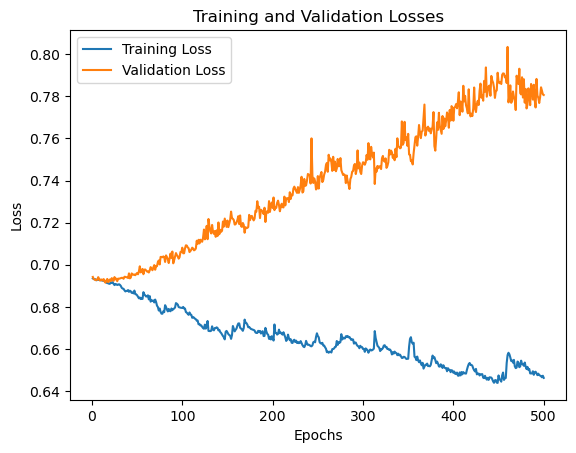

In [9]:
# train RNN model

start_time = time.time()

train_loss, validation_loss = Torch_LSTM_RNN.train_model(train_dataloader = train_dataloader,
                                                       validation_dataloader = validation_dataloader,
                                                       num_epochs = num_epochs,
                                                       loss_kind = loss_kind,
                                                       optimizer = optimizer)

# print train time
elapsed_time = ((time.time() - start_time) / 60)
print()
print("Elapsed model training time:\n{:.2f} minutes".format(elapsed_time))

# plot loss curves

plt.figure()
plt.plot(range(1, num_epochs + 1), train_loss, label = 'Training Loss')
plt.plot(range(1, num_epochs + 1), validation_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

#### 6. Calculate and report the performance of your model on the training and test set. 15 points
- Calculate the accuracies on the training and test sets
- Print out the confusion matrix of model results on the test set: https://scikit-learn.org/dev/modules/generated/sklearn.metrics.confusion_matrix.html

In [10]:
# evaluate model

train_accuracy, Y_train_hat, Y_train = Torch_LSTM_RNN.evaluate(train_dataloader)
test_accuracy, Y_test_hat, Y_test = Torch_LSTM_RNN.evaluate(train_dataloader)

# print accuracies

print("Training accuracy:\n", train_accuracy)
print()
print("Test accuracy:\n", test_accuracy)
print()

# confusion matrices

print("Confusion matrix for train set:\n", confusion_matrix(Y_train, Y_train_hat))
print()
print("Confusion matrix for test set:\n", confusion_matrix(Y_test, Y_test_hat))
print()


Training accuracy:
 0.5738

Test accuracy:
 0.5718

Confusion matrix for train set:
 [[ 3912  8527]
 [ 2128 10433]]

Confusion matrix for test set:
 [[ 3866  8573]
 [ 2132 10429]]

